# Распознавание лиц при помощи SVM и kernel trick

# Описание набора данных

В этом задании вам предлагается построить классификатор, обученный на изображениях лиц. Сначала загрузим необходимый набор данных и посмотрим, что он из себя представляет. 

Таблица содержит "распрямленные" представления изображений лиц людей.

Изначально каждое изображение — матрица размера $62 \times 47$, значения которой, предположительно, нормированы к диапазону $[0, 1]$ из диапазона $[0, 255] \cap \mathbb Z$. Сами значения отвечают за интенсивность пикселя: чем значение больше, тем пиксель светлее.

Обратите внимание, из картинки (или, что то же самое, матрицы) размера $62 \times 47$ получился вектор длины $2914 = 62 \cdot 47$.

Колонка <code>label</code> отвечает за имя человека, изображенного на картинке.

In [2]:
import pandas as pd    
df = pd.read_csv('persons_pics_train.csv')
df.sort_values(by=['label'], inplace=True)
# df.head()
df[['label','0']]

,label,0
620,Ariel Sharon,0.890196
1112,Ariel Sharon,0.509804
1303,Ariel Sharon,0.401307
805,Ariel Sharon,0.464052
1241,Ariel Sharon,0.789543
...,...,...
1230,Tony Blair,0.135948
686,Tony Blair,0.172549
1232,Tony Blair,0.845752
728,Tony Blair,0.243137


Убедимся в том, что перед нами действительно изображения лиц людей. Возьмем первые $15$ строк из таблицы исходных данных и построим соответствующие им изображения.

In [63]:
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

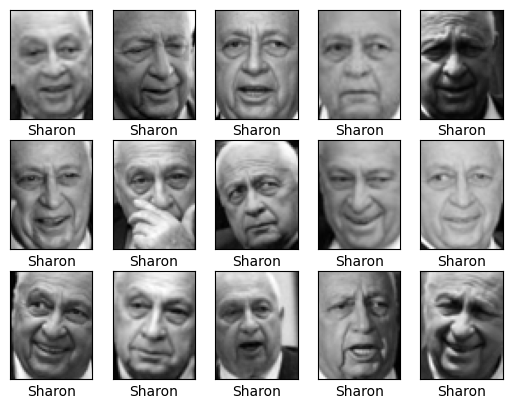

In [73]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(df.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

Крупнее

(-0.5, 46.5, 61.5, -0.5)

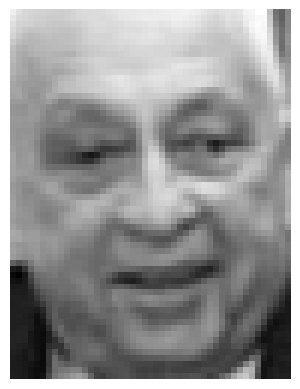

In [11]:
plt.imshow(df.iloc[0].drop('label').astype(float).to_numpy().reshape(62,47), cmap='gray')
plt.axis('off')

# Немного озорства

Определите число различных людей, фотографии которых содержатся в рассматриваемом наборе данных.

In [12]:
# < ENTER YOUR CODE HERE > 
df.nunique ()

0        548
1        552
2        557
3        557
4        582
        ... 
2910     696
2911     684
2912     661
2913     656
label     12
Length: 2915, dtype: int64

Постройте гистограмму распределения объектов по классам и вычислите долю объектов каждого класса. 

In [17]:
# < ENTER YOUR CODE HERE > 
df['label'].value_counts()

label
George W Bush        451
Colin Powell         201
Tony Blair           122
Donald Rumsfeld      103
Gerhard Schroeder     93
Ariel Sharon          65
Hugo Chavez           60
Junichiro Koizumi     51
Jean Chretien         47
John Ashcroft         45
Jacques Chirac        44
Serena Williams       44
Name: count, dtype: int64

На основе имеющихся данных поставьте в соответствие каждому человеку один вектор, координаты которого являются средним соответствующих координат всех векторов, отождествленных с этим человеком.

In [96]:
# < ENTER YOUR CODE HERE > 
# Группируем данные по человеку и вычисляем средний вектор
average_vectors = df.groupby('label').mean().reset_index()

# Вначале удаляем столбец 'label'
label = average_vectors['label']
average_vectors = average_vectors.drop('label', axis=1)
average_vectors['label'] = label
average_vectors

,0,1,2,3,4,5,6,7,8,9,...,2905,2906,2907,2908,2909,2910,2911,2912,2913,label
0,0.501398,0.514811,0.532609,0.551714,0.569754,0.577456,0.581820,0.591835,0.604465,0.612589,...,0.433947,0.478291,0.519920,0.532549,0.515656,0.498220,0.486657,0.466928,0.437687,Ariel Sharon
1,0.433512,0.441147,0.456248,0.471947,0.486730,0.513732,0.545157,0.566514,0.581556,0.592924,...,0.471798,0.512067,0.534615,0.532176,0.510006,0.477586,0.448119,0.410659,0.379605,Colin Powell
2,0.404810,0.417260,0.442731,0.474028,0.507938,0.541659,0.560112,0.571838,0.585773,0.602386,...,0.546837,0.562307,0.558627,0.549426,0.525947,0.500603,0.475550,0.431893,0.391738,Donald Rumsfeld
3,0.348179,0.360263,0.381659,0.416669,0.457154,0.488335,0.515398,0.536075,0.551153,0.565662,...,0.414092,0.441074,0.461325,0.470275,0.459067,0.447653,0.430523,0.399620,0.376584,George W Bush
4,0.210162,0.228210,0.268255,0.328344,0.389332,0.447115,0.495003,0.527655,0.549441,0.569457,...,0.430937,0.469281,0.494596,0.496718,0.482550,0.442252,0.428477,0.426875,0.411118,Gerhard Schroeder
5,0.206885,0.205142,0.240828,0.300806,0.370196,0.427712,0.471939,0.512702,0.545251,0.562070,...,0.360523,0.372200,0.385926,0.394662,0.392309,0.384989,0.371503,0.372440,0.374052,Hugo Chavez
6,0.348010,0.368152,0.405704,0.436988,0.462686,0.498693,0.531135,0.553060,0.574629,0.594029,...,0.469935,0.480957,0.486067,0.510933,0.537998,0.542751,0.505853,0.456625,0.434997,Jacques Chirac
7,0.388958,0.412488,0.446614,0.487637,0.526158,0.563315,0.594827,0.628981,0.665026,0.685774,...,0.574190,0.583452,0.555667,0.499764,0.455180,0.426060,0.415353,0.414713,0.397608,Jean Chretien
8,0.337894,0.334379,0.337662,0.357037,0.384779,0.397182,0.412375,0.431924,0.449441,0.466986,...,0.468468,0.475759,0.489092,0.512999,0.540944,0.534524,0.524415,0.527495,0.527495,John Ashcroft
9,0.268384,0.253672,0.249699,0.257875,0.297373,0.352044,0.403306,0.441394,0.470819,0.494656,...,0.530437,0.561169,0.558657,0.542304,0.537896,0.532359,0.516750,0.498347,0.509753,Junichiro Koizumi


Вычислите координату с индексом $0$ усредненного вектора, соответствующего человеку из вашего индивидуального задания.

In [93]:
# < ENTER YOUR CODE HERE > 
average_vectors[['label','0']]

,label,0
0,Ariel Sharon,0.501398
1,Colin Powell,0.433512
2,Donald Rumsfeld,0.404810
3,George W Bush,0.348179
4,Gerhard Schroeder,0.210162
5,Hugo Chavez,0.206885
6,Jacques Chirac,0.348010
7,Jean Chretien,0.388958
8,John Ashcroft,0.337894
9,Junichiro Koizumi,0.268384


Используя усредненные векторы, постройте изображения всех людей из набора данных.

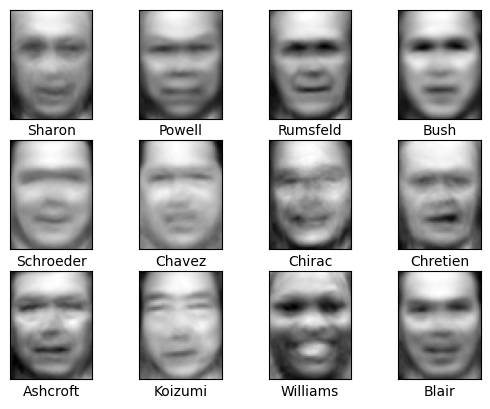

In [99]:
# < ENTER YOUR CODE HERE > 
import matplotlib.pyplot as plt

def get_img_by_row(row):
  return row.drop('label').astype(float).to_numpy().reshape(62,47), row['label']

fig, ax = plt.subplots(3, 4)
for i, axi in enumerate(ax.flat):
    img, lbl = get_img_by_row(average_vectors.iloc[i])
    axi.imshow(img, cmap='gray')
    axi.set(xticks=[], yticks=[],
            xlabel=lbl.split()[-1])

В качестве меры "схожести" двух объектов часто используют так называемое [косинусное сходство](https://en.wikipedia.org/wiki/Cosine_similarity). Не следует путать с косинусным расстоянием.

Постройте матрицу "схожести" объектов на основе их усредненных векторов. Для визуализации рекомендуем использовать тепловую карту, например, [из библиотеки seaborn](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

[0.99317214 0.99513082 0.99515232 0.99622325 0.99722896 0.99518468
 1.         0.99334977 0.99617187 0.9947458  0.98347907 0.99628436]


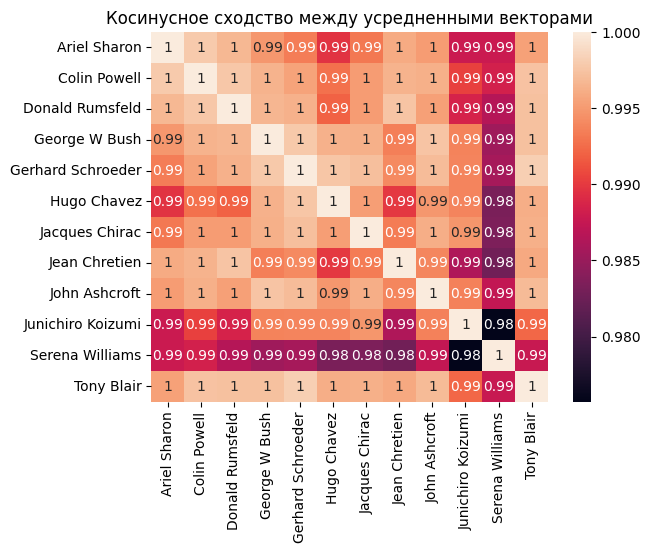

In [4]:
# < ENTER YOUR CODE HERE > 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

average_vectors = df.groupby('label').mean().reset_index()
cosine_sim = cosine_similarity(average_vectors.iloc[:, 1:].values)
print(cosine_sim[6])

sns.heatmap(cosine_sim, annot=True, xticklabels=average_vectors['label'], yticklabels=average_vectors['label'])
plt.title('Косинусное сходство между усредненными векторами')
plt.show()

Определите косинусное сходство для пары людей из вашего индивидуального задания на основе соответствующих им "усредненных" векторов.

In [ ]:
# < ENTER YOUR CODE HERE > 
# смотри выше

# Построение модели

При помощи <code>train_test_split()</code> разделите набор данных на тренировочный и тестовый с параметрами, указанными в вашем индивидуальном задании. Используйте стратификацию по колонке <code>label</code>.

In [ ]:
# < ENTER YOUR CODE HERE > 

## Первое приближение: базовый SVM классификатор с линейным ядром.

Обучите модель <code>SVC()</code> на тренировочном наборе данных с параметрами, указанными в вашем индивидуальном задании.

In [ ]:
# < ENTER YOUR CODE HERE > 

Оцените модель на тестовых данных. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE > 

В целом, достаточно неплохой результат, но имеет смысл попробовать подобрать параметры.

## Подбор гиперпараметров

Используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей

In [ ]:
# < ENTER YOUR CODE HERE > 

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE > 

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>.

In [ ]:
# < ENTER YOUR CODE HERE > 

## Уменьшение размерности

Обучение было долгим. Имеет смысл проверить, что будет если уменьшить размерность входных данных, например, при помощи <code>PCA</code>. Обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных и определите минимальное количество компонент, необходимое для того, чтобы уровень объясненной дисперсии был больше <code>0.95</code>.

In [ ]:
# < ENTER YOUR CODE HERE > 

Заново обучите модель <code>PCA(svd_solver='full')</code> на тренировочных данных с использованием полученного числа ГК. Примените полученное преобразование для тренировочных и тестовых данных.

In [ ]:
# < ENTER YOUR CODE HERE > 

Для полученных после <code>PCA</code> данных аналогично проделанному ранее, то есть используя <code>GridSearchCV()</code>, осуществите подбор гиперпараметров, указанных в вашем задании. Отдельно обратите внимание на время обучения моделей.

In [ ]:
# < ENTER YOUR CODE HERE > 

Определите гиперпараметры лучшей полученной модели.

In [ ]:
# < ENTER YOUR CODE HERE > 

Выполните предсказание для тестовых данных при помощи лучшей полученной модели. Вычислите <code>f1_score(average='weighted')</code>

In [ ]:
# < ENTER YOUR CODE HERE > 

Видно, что качество модели изменилось незначительно, при этом время обучения существенно сократилось.